In [1]:
#we first import the main libraries
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None, 'display.max_rows', 100)

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.style.use('ggplot')
from IPython.display import display
import seaborn as sns
sns.set_style("darkgrid")
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
import xgboost as xgb

from sklearn import neighbors
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
path = "..//Data//atp_data_clean.csv"
df = pd.read_csv(path)
df.info(null_counts = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44105 entries, 0 to 44104
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   44105 non-null  int64  
 1   ATP          44105 non-null  int64  
 2   Location     44105 non-null  object 
 3   Tournament   44105 non-null  object 
 4   Date         44105 non-null  object 
 5   Series       44105 non-null  object 
 6   Court        44105 non-null  object 
 7   Surface      44105 non-null  object 
 8   Round        44105 non-null  object 
 9   Best of      44105 non-null  int64  
 10  Winner       44105 non-null  object 
 11  Loser        44105 non-null  object 
 12  WRank        44105 non-null  int64  
 13  LRank        44105 non-null  int64  
 14  Wsets        44105 non-null  float64
 15  Lsets        44105 non-null  float64
 16  Comment      44105 non-null  object 
 17  PSW          44105 non-null  float64
 18  PSL          44105 non-null  float64
 19  B365

C:\Users\Olia\AppData\Local\Temp/ipykernel_3272/2652338970.py:3: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts = True, verbose = True)


In [3]:
#liste de tous les winners et losers 
x = pd.concat([df.Winner, df.Loser], axis = 0)

In [4]:
#calcul du nombre de joueurs dans la base
print("il y", len(np.unique(x)), "joueurs présents dans la base")

il y 1381 joueurs présents dans la base


In [5]:
#quels sont les joueurs les plus présents
x.value_counts()

Federer R.         1148
Nadal R.            976
Ferrer D.           949
Djokovic N.         832
Berdych T.          803
                   ... 
Jun W.                1
Schuttler P.          1
Fish A.               1
Chaen T.              1
Seyboth Wild T.       1
Length: 1381, dtype: int64

In [6]:
df = df.drop(columns = ["Unnamed: 0"])

On va chercher à exhiber l'evolution du classement Elo de Federer et son classement ATP

In [7]:
#On récupère le groupe Federer dans l'ensemble winner et looser
federer_winner = df.groupby("Winner").get_group("Federer R.")
federer_loser = df.groupby("Loser").get_group("Federer R.")
#On ne retient que les colonnes qui nous intéressent
federer_winner = federer_winner.loc[:,["Date", "WRank", "elo_winner"]]
federer_loser = federer_loser.loc[:,["Date", "LRank", "elo_loser"]]

In [8]:
#On renomme les colonnes
federer_loser = federer_loser.rename(columns={"LRank": "Rank", "elo_loser": "elo"})
federer_winner = federer_winner.rename(columns={"WRank": "Rank", "elo_winner": "elo"})

In [9]:
#On concatene winner et looser puis on tri sur les dates
federer = pd.concat([federer_winner, federer_loser], axis = 0)
federer = federer.sort_values(by = "Date")

In [10]:
federer = federer.set_index("Date")

In [11]:
federer

,Rank,elo
Date,,
2000-01-03,65,1484.000000
2000-01-03,65,1500.000000
2000-01-10,61,1500.736307
2000-01-17,62,1500.639183
2000-01-17,62,1484.702399
...,...,...
2018-02-14,2,2208.929737
2018-02-15,2,2209.717110
2018-02-16,2,2211.727906


In [12]:
#On réalise un min max scaling pour avoir les valeurs sur la meme échelle
scaler = MinMaxScaler()
scaler.fit(federer)
federer_scaled = pd.DataFrame(scaler.transform(federer), index = federer.index, columns = federer.columns)

In [13]:
federer_scaled

,Rank,elo
Date,,
2000-01-03,0.969697,0.020898
2000-01-03,0.969697,0.039987
2000-01-10,0.909091,0.040865
2000-01-17,0.924242,0.040749
2000-01-17,0.924242,0.021736
...,...,...
2018-02-14,0.015152,0.885765
2018-02-15,0.015152,0.886705
2018-02-16,0.015152,0.889104


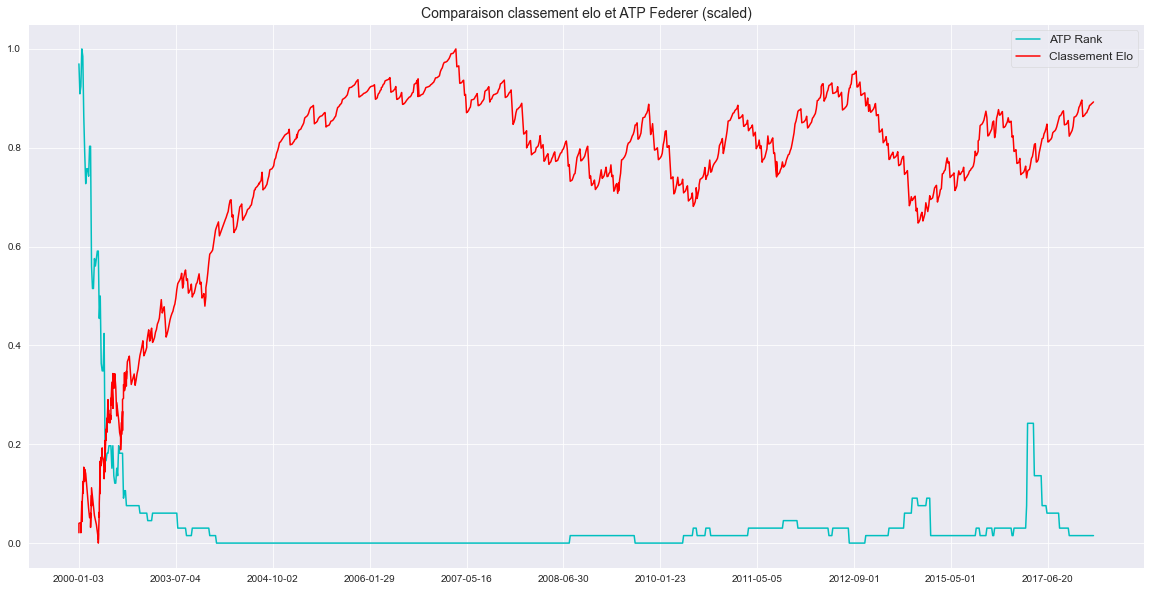

In [14]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(111)

t = ax1.set_title("Comparaison classement elo et ATP Federer (scaled)", fontsize = 14)

ax1.plot(federer_scaled.index, federer_scaled["Rank"],"c", label = "ATP Rank")
ax1.plot(federer_scaled.index, federer_scaled["elo"],"red", label = "Classement Elo")

locs_x, labels_x = plt.xticks()
locs_y, labels_y = plt.yticks()
loc_x_new = np.arange(locs_x[0], locs_x[-1], step = 100)
plt.xticks(loc_x_new)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

ax1.legend(loc = "best",  fontsize = 12);

In [15]:
#On analyse la distribution des cotes
cote_winner = df.loc[:,["Date", "PSW", "B365W"]]
cote_loser = df.loc[:,["Date", "PSL", "B365L"]]

In [16]:
cote_loser = cote_loser.rename(columns={"PSL": "PS", "B365L": "B365"})
cote_winner = cote_winner.rename(columns={"PSW": "PS", "B365W": "B365"})

In [17]:
cote = pd.concat([cote_winner, cote_loser], axis = 0)
cote = cote.set_index("Date")

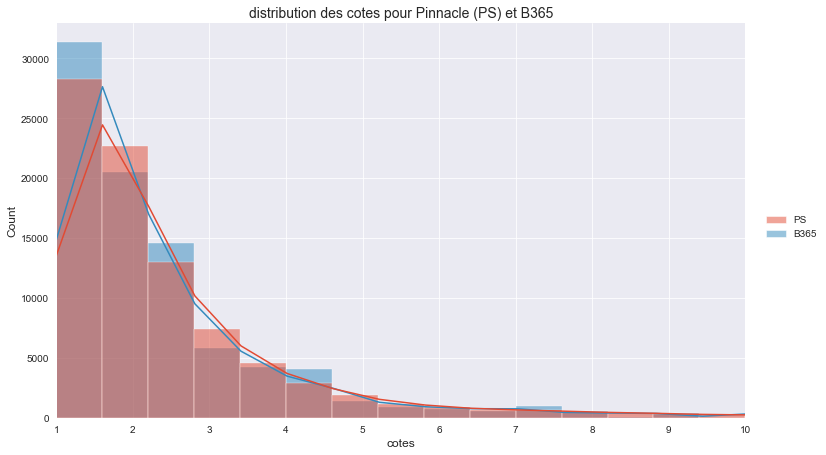

In [18]:
ax1 = sns.displot(cote[['PS', "B365"]],height=6, aspect=16/9,  bins = 200, kde = True)
plt.xlim(1,10)
plt.title("distribution des cotes pour Pinnacle (PS) et B365", fontsize = 14)
plt.xlabel("cotes", fontsize = 12)
plt.show();

In [19]:
#analyse de la distribution du rapport des cotes
rapport_cote = cote['PS']/cote["B365"]

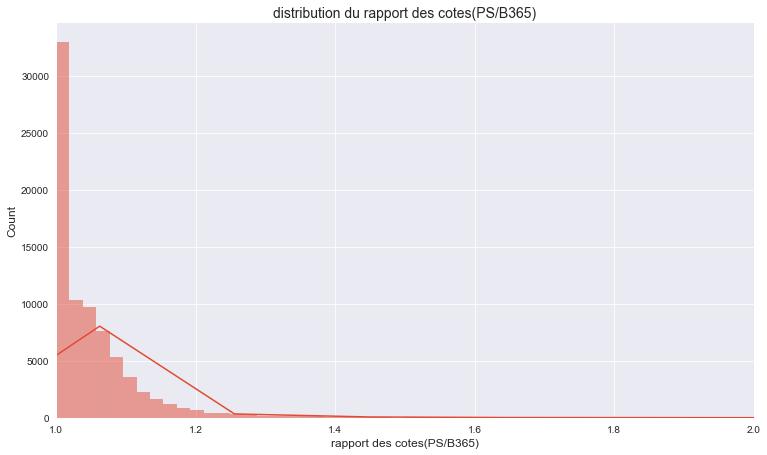

In [20]:
ax1 = sns.displot(rapport_cote, height=6, aspect=16/9,  bins = 2000, kde = True)
plt.xlim(1,2)
plt.title("distribution du rapport des cotes(PS/B365)", fontsize = 14)
plt.xlabel("rapport des cotes(PS/B365)", fontsize = 12)
plt.show();

In [21]:
rapport_cote.describe()

count    88210.000000
mean         1.051398
std          0.186112
min          0.095455
25%          1.000000
50%          1.024096
75%          1.068182
max         38.571429
dtype: float64

In [22]:
rapport_cote.quantile(0.99)

1.46875

In [24]:
#tentative de génération d'un moteur de trading automatique (non utilisé dans le rapport)
path = "DTB_Rolling_Features_ratios_w30_clean_withupset.csv"
df = pd.read_csv(path)

In [25]:
#we delete columns added when saving csv
df = df.drop(columns = ["Unnamed: 0"])
#we delete columns not useful for our classification
df = df.drop(columns = [              
              'Sets1', 'Sets2',
              'Comment',
              'tourney_id',
              'p1_id', 'p2_id',
              'score',
              'minutes',
              'tourney_year', 'tourney_month', 'tourney_day',
              'p1_1', 'p2_1', 'p1_2', 'p2_2', 'p1_3', 'p2_3', 'p1_4', 'p2_4', 'p1_5', 'p2_5',
              'p1_sets', 'p2_sets',
               #'p1_UpsetScored', 'p2_UpsetScored', 'p1_UpsetAgainst', 'p2_UpsetAgainst', #essayer en les intégrant dans le rolling
              #we used these data to compute the other features :
              'p1_ace',
             'p1_df',
             'p1_svpt',
             'p1_1stIn',
             'p1_1stWon',
             'p1_2ndWon',
             'p1_SvGms',
             'p1_bpSaved',
             'p1_bpFaced',
             'p2_ace',
             'p2_df',
             'p2_svpt',
             'p2_1stIn',
             'p2_1stWon',
             'p2_2ndWon',
             'p2_SvGms',
             'p2_bpSaved',
             'p2_bpFaced'  ])
             

In [26]:
#we delete the remaining NAs and infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(axis = 0)
df = df.drop(columns = df.columns[64:66])

In [27]:
df.columns

Index(['Tournament', 'Date', 'Court', 'Surface', 'p1_name', 'p2_name',
       'ratio_rank', 'p1_PS', 'p2_PS', 'p1_B365', 'p2_B365', 'ratio_elo',
       'proba_elo', 'tourney_level', 'p1_seed', 'p1_entry', 'p1_hand',
       'ratio_ht', 'ratio_age', 'p2_seed', 'p2_entry', 'p2_hand', 'round',
       'ratio_rank_points', 'p1_win', 'ratio_1stWon%', 'ratio_2ndWon%',
       'ratio_1stServeEffectiveness', 'ratio_Ret2ServPtsRatio',
       'ratio_ServeWon%', 'ratio_ReturnWon%', 'ratio_PtsDominanceRatio',
       'ratio_BPConverted%', 'ratio_BPRatio', 'ratio_SetWon%', 'ratio_PtsWon%',
       'ratio_Pts2Sets_OP_Ratio', 'ratio_GmsWon%', 'ratio_Pts2Gms_OP_Ratio',
       'ratio_Gms2Sets_OP_Ratio', 'ratio_BPWon%', 'ratio_BP_OP_Ratio',
       'ratio_BPSaved%', 'ratio_BPSaved_OP_Ratio',
       'ratio_BPConverted_OP_Ratio', 'ratio_Ace%', 'ratio_DF%',
       'ratio_1stServe%', 'ratio_1stReturnWon%', 'ratio_UpsetScored',
       'ratio_UpsetAgainst', 'p1_rank_change', 'p2_rank_change',
       'p1_rank_points

In [28]:
p1 = df.groupby("p1_name").get_group("FEDERER R.")
p2 = df.groupby("p2_name").get_group("FEDERER R.")
p1 = p1.loc[:,["Date", "p1_elo_change"]]
p2 = p2.loc[:,["Date", "p2_elo_change"]]

In [29]:
p1 = p1.rename(columns={"p1_elo_change": "elo_change"})
p2 = p2.rename(columns={"p2_elo_change": "elo_change"})

In [30]:
elo_change = pd.concat([p1, p2], axis = 0)
elo_change = elo_change.sort_values(by = "Date")

In [31]:
elo_change = elo_change.set_index("Date")

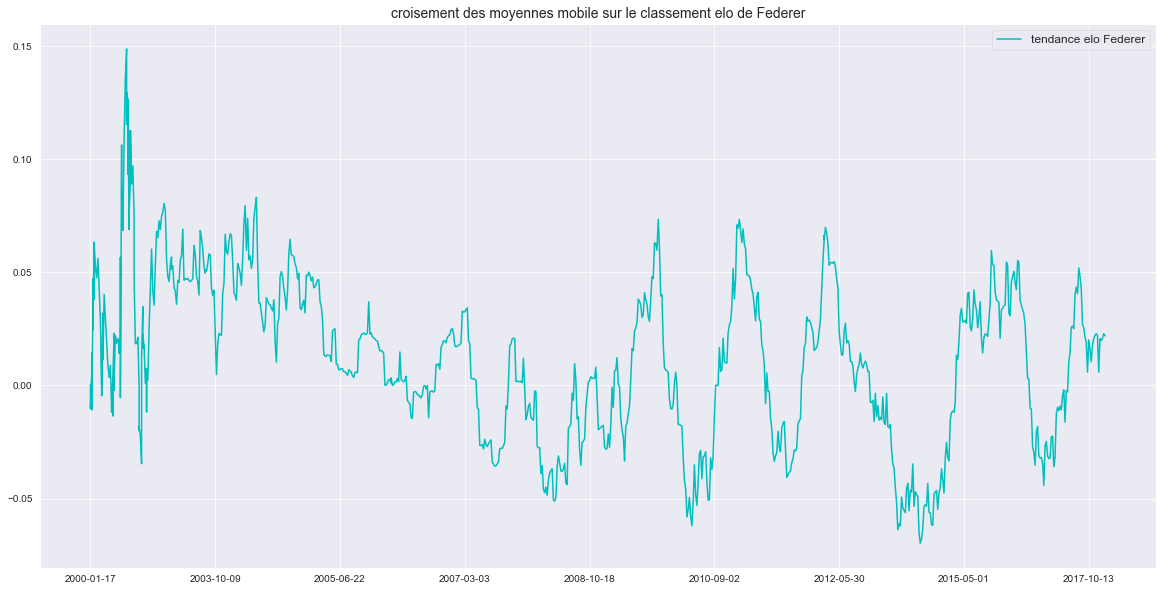

In [32]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(111)

t = ax1.set_title("croisement des moyennes mobile sur le classement elo de Federer", fontsize = 14)

ax1.plot(elo_change,"c", label = "tendance elo Federer")

locs_x, labels_x = plt.xticks()
locs_y, labels_y = plt.yticks()
loc_x_new = np.arange(locs_x[0], locs_x[-1], step = 100)
plt.xticks(loc_x_new)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

ax1.legend(loc = "best",  fontsize = 12);

In [33]:
#On choisit les matchs ou la tendance du classement elo joueur 1 est positive
#la tendance du classement elo du joueur 2 est negative
#la proba elo que le joueur 1 gagne le match est supérieur à 0.7
#Le joueur 1 a une cote plus grande que le joueur 2

index = list(df.loc[(df["p1_elo_change"] > 0) & (df["proba_elo"] > 0.7) & (df["p2_elo_change"] < 0) &
                    (df["p1_PS"] > df["p2_PS"])].index)
#

In [34]:
#Sur cette ensemble on a les stats suivantes :
print(df['p1_win'].loc[index].sum() / df['p1_win'].loc[index].shape, "accuracy")
print(df['p1_PS'].loc[index].mean(), "moyenne des cotes p1")
print(df['p2_PS'].loc[index].mean(), "moyenne des cotes p2")
print(df['p1_win'].loc[index].shape[0], "nb matchs")

[0.41525424] accuracy
2.495644067796611 moyenne des cotes p1
1.6666016949152542 moyenne des cotes p2
118 nb matchs


In [35]:
#On crée un nouveau dataframe df_new
df_new = df.loc[index]

In [36]:
#calcul du Pnl dynamic
pnl_dynamic = pd.DataFrame(np.where(df_new["p1_win"] == True, 
                                    df_new['p1_PS'] - 1, -1), index = df_new['Date'], columns = ['pnl'])

In [37]:
pnl_dynamic = pnl_dynamic.sort_values(by = 'Date')

In [38]:
pnl_small = pd.DataFrame(np.where(df_new["p1_win"] == True, - 1, df_new['p2_PS'] - 1), index = df_new['Date'], columns = ['pnl'])

In [39]:
pnl_small = pnl_small.sort_values(by = 'Date')

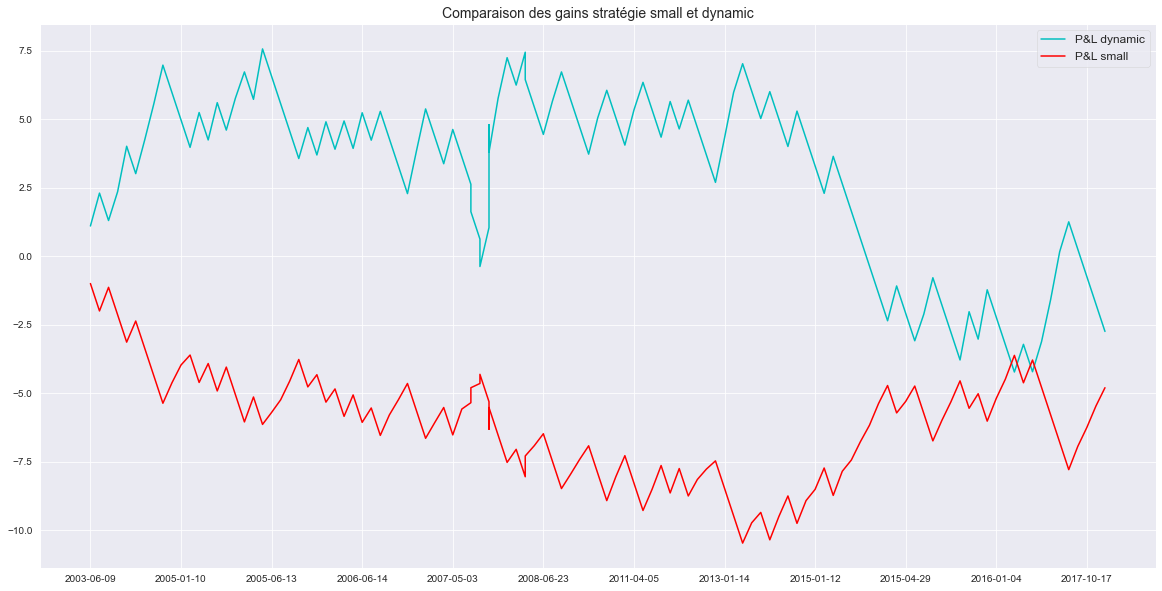

In [40]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(111)

t = ax1.set_title("Comparaison des gains stratégie small et dynamic", fontsize = 14)

ax1.plot(pnl_dynamic.cumsum(),"c", label = "P&L dynamic")
ax1.plot(pnl_small.cumsum(),"r", label = "P&L small")

locs_x, labels_x = plt.xticks()
locs_y, labels_y = plt.yticks()
loc_x_new = np.arange(locs_x[0], locs_x[-1], step = 10)
plt.xticks(loc_x_new)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

ax1.legend(loc = "best",  fontsize = 12);

In [41]:
path = "..//Data//DTB_Rolling_Features_ratios_w30_clean_withupset.csv"
df = pd.read_csv(path)

#we delete columns added when saving csv
df = df.drop(columns = ["Unnamed: 0"])
#we delete columns not useful for our classification
df = df.drop(columns = [              
              'Sets1', 'Sets2',
              'Comment',
              'tourney_id',
              'p1_id', 'p2_id',
              'score',
              'minutes',
              'tourney_year', 'tourney_month', 'tourney_day',
              'p1_1', 'p2_1', 'p1_2', 'p2_2', 'p1_3', 'p2_3', 'p1_4', 'p2_4', 'p1_5', 'p2_5',
              'p1_sets', 'p2_sets',
               #'p1_UpsetScored', 'p2_UpsetScored', 'p1_UpsetAgainst', 'p2_UpsetAgainst', #essayer en les intégrant dans le rolling
              #we used these data to compute the other features :
              'p1_ace',
             'p1_df',
             'p1_svpt',
             'p1_1stIn',
             'p1_1stWon',
             'p1_2ndWon',
             'p1_SvGms',
             'p1_bpSaved',
             'p1_bpFaced',
             'p2_ace',
             'p2_df',
             'p2_svpt',
             'p2_1stIn',
             'p2_1stWon',
             'p2_2ndWon',
             'p2_SvGms',
             'p2_bpSaved',
             'p2_bpFaced'  ])

#we delete the remaining NAs and infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(axis = 0)
df = df.drop(columns = df.columns[64:66])

In [42]:
#on va tenter d'autres stratégie
#jouer la cote la plus faible clean data

df['gainP_small'] = df['p1_PS']

#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):
    if df["p1_PS"].iloc[i] < df["p2_PS"].iloc[i] and df["p1_win"].iloc[i] == True:
        df["gainP_small"].iloc[i] = df["p1_PS"].iloc[i] - 1
    elif df["p2_PS"].iloc[i] < df["p1_PS"].iloc[i] and df["p1_win"].iloc[i] == False:
        df["gainP_small"].iloc[i] = df["p2_PS"].iloc[i] - 1 
    else:
        df["gainP_small"].iloc[i] = -1
        
df["PnLP_small"] = df["gainP_small"].cumsum()

D:\Olia\Documents\Papa\Conda\envs\jupyter\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [43]:
df.shape

(63044, 59)

In [44]:
#Cette stratégie joue si un joueur non favori (plus grande cote) a 
#une proba elo > 50% de gagner le match

#df['gainP_dynamic_50%'] = df['p1_PS']
cpt = 0
l = []
o = 2.5
#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):
     
    if df["p1_PS"].iloc[i] >= df["p2_PS"].iloc[i]:
        if df["proba_elo"].iloc[i] > 0.50 and df["p1_PS"].iloc[i] < o:
            cpt = cpt + 1
            if df["p1_win"].iloc[i] == True:
                l.append(df["p1_PS"].iloc[i] - 1)
            else:
                l.append(-1)
        else:
            l.append(0)
                
    if df["p2_PS"].iloc[i] > df["p1_PS"].iloc[i]:
        if 1 - df["proba_elo"].iloc[i] > 0.50 and df["p2_PS"].iloc[i] < o:
            cpt = cpt + 1
            if df["p1_win"].iloc[i] == False:
                l.append(df["p2_PS"].iloc[i] - 1)
            else:
                l.append(-1)
        else:
            l.append(0)
        
g50 = pd.Series(l)
df["gainP_dynamic_50%"] = g50
print(cpt)

4995


In [45]:
df.shape

(63044, 60)

In [46]:
#idem que la cellule précédente mais avec un seuil à 60%

#df['gainP_dynamic_50%'] = df['p1_PS']
cpt = 0
l = []
d = []
#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):
     
    if df["p1_PS"].iloc[i] >= df["p2_PS"].iloc[i]:
        if df["proba_elo"].iloc[i] > 0.60 and df["p1_PS"].iloc[i] < o:
            cpt = cpt + 1
            if df["p1_win"].iloc[i] == True:
                l.append(df["p1_PS"].iloc[i] - 1)
            else:
                l.append(-1)
        else:
            l.append(0)
                
    if df["p2_PS"].iloc[i] > df["p1_PS"].iloc[i]:
        if 1 - df["proba_elo"].iloc[i] > 0.60 and df["p2_PS"].iloc[i] < o:
            cpt = cpt + 1
            if df["p1_win"].iloc[i] == False:
                l.append(df["p2_PS"].iloc[i] - 1)
            else:
                l.append(-1)
        else:
            l.append(0)
        
g60 = pd.Series(l)
df["gainP_dynamic_60%"] = g60
print(cpt)

1677


In [47]:
#idem que la cellule précédente mais avec un seuil à 70%

#df['gainP_dynamic_50%'] = df['p1_PS']
cpt = 0
l = []
d = []
#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):
     
    if df["p1_PS"].iloc[i] >= df["p2_PS"].iloc[i]:
        if df["proba_elo"].iloc[i] > 0.70 and df["p1_PS"].iloc[i] < o:
            cpt = cpt + 1
            if df["p1_win"].iloc[i] == True:
                l.append(df["p1_PS"].iloc[i] - 1)
            else:
                l.append(-1)
        else:
            l.append(0)
                
    if df["p2_PS"].iloc[i] > df["p1_PS"].iloc[i]:
        if 1 - df["proba_elo"].iloc[i] > 0.70 and df["p2_PS"].iloc[i] < o:
            cpt = cpt + 1
            if df["p1_win"].iloc[i] == False:
                l.append(df["p2_PS"].iloc[i] - 1)
            else:
                l.append(-1)
        else:
            l.append(0)
        
g70 = pd.Series(l)
df["gainP_dynamic_70%"] = g70
print(cpt)

402


In [48]:
#idem que la cellule précédente mais avec un seuil à 80%

#df['gainP_dynamic_50%'] = df['p1_PS']
cpt = 0
l = []
d = []
#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):
     
    if df["p1_PS"].iloc[i] >= df["p2_PS"].iloc[i]:
        if df["proba_elo"].iloc[i] > 0.80 and df["p1_PS"].iloc[i] < o:
            cpt = cpt + 1
            if df["p1_win"].iloc[i] == True:
                l.append(df["p1_PS"].iloc[i] - 1)
            else:
                l.append(-1)
        else:
            l.append(0)
                
    if df["p2_PS"].iloc[i] > df["p1_PS"].iloc[i]:
        if 1 - df["proba_elo"].iloc[i] > 0.80 and df["p2_PS"].iloc[i] < o:
            cpt = cpt + 1
            if df["p1_win"].iloc[i] == False:
                l.append(df["p2_PS"].iloc[i] - 1)
            else:
                l.append(-1)
        else:
            l.append(0)
        
g80 = pd.Series(l)
df["gainP_dynamic_80%"] = g80
print(cpt)

54


In [49]:
len(l)

63044

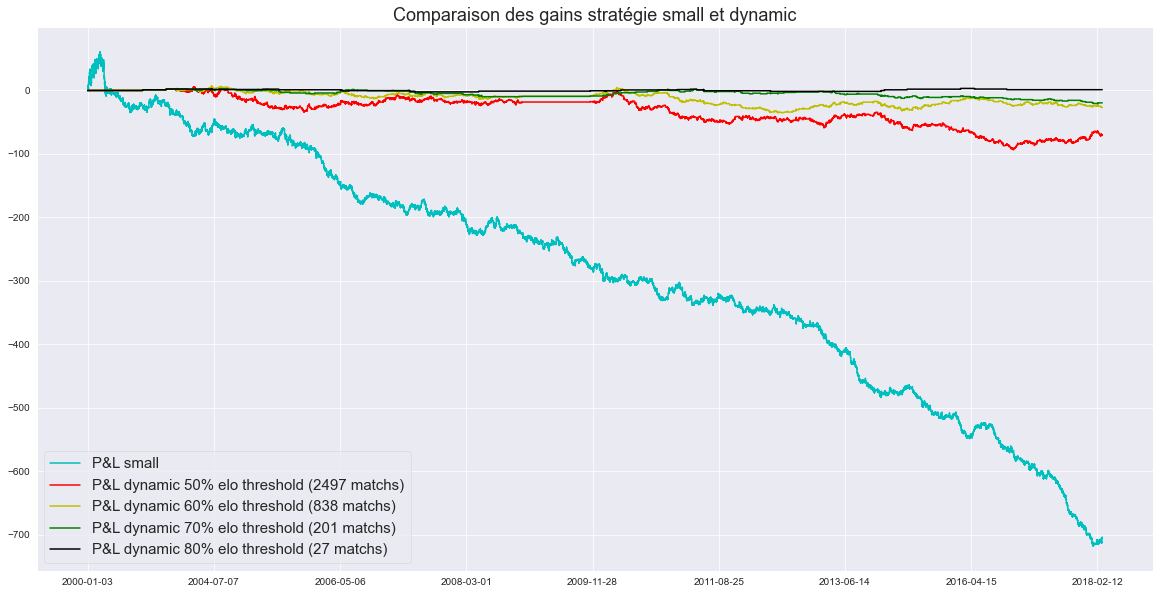

In [50]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(111)

t = ax1.set_title("Comparaison des gains stratégie small et dynamic", fontsize = 18)

ax1.plot(df.Date, df.PnLP_small / 2,"c", label = "P&L small")
ax1.plot(df.Date, g50.cumsum() / 2,"r", label = "P&L dynamic 50% elo threshold (2497 matchs)")
ax1.plot(df.Date, g60.cumsum() / 2,"y", label = "P&L dynamic 60% elo threshold (838 matchs)")
ax1.plot(df.Date, g70.cumsum() / 2,"g", label = "P&L dynamic 70% elo threshold (201 matchs)")
ax1.plot(df.Date, g80.cumsum() / 2,"k", label = "P&L dynamic 80% elo threshold (27 matchs)")

locs_x, labels_x = plt.xticks()
locs_y, labels_y = plt.yticks()
loc_x_new = np.arange(locs_x[0], locs_x[-1], step = 500)
plt.xticks(loc_x_new)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

ax1.legend(loc = "lower left",  fontsize = 15);

In [51]:
#Les phase de plat sont dues aux cotes pinnacle manquantes, on a alors extrapolé ces cotes a partir de la proba elo, 
#donc la cote est nécessairement dans le même sens que la proba elo ce qui implique que la stratégie ne joue pas

In [52]:
#Calul de statistique des rique (inutile car les strats sont perdantes)
def MDD(gain):
    dd = []
    dd.append(0)
    for i in range(1, gain.shape[0]):
        dd.append(gain.iloc[0:i].max() - gain.iloc[i])
    return max(dd)

In [53]:
#Calul et affichage de statistique des rique (inutile car les strats sont perdantes)
def CalcStat(colname):
    pnl = colname.cumsum() / 2 #les matchs sont doublonnés
    vol = round(colname.std() * np.sqrt(365.25), 2)
    ret = round(pnl.iloc[-1] / 18, 2)
    sha = round(ret / vol, 2)
    mdd = round(-MDD(pnl), 2)
    cal = round(ret / -mdd, 2)
    
    ar = np.array([vol, ret, sha, cal, mdd])
    PerfRecap = pd.DataFrame(ar, index = ['Volatility', 'Yearly average PnL', 'Sharpe', 'Calmar', 'Max DrawDown'],columns = ['Stats'] )
    display(PerfRecap)
    
    return [vol, ret, sha, cal, mdd]

In [54]:
l50 = CalcStat(g50)
l60 = CalcStat(g60)
l70 = CalcStat(g70)
l80 = CalcStat(g80)

,Stats
Volatility,5.82
Yearly average PnL,-3.93
Sharpe,-0.68
Calmar,-0.04
Max DrawDown,-99.18


,Stats
Volatility,3.35
Yearly average PnL,-1.49
Sharpe,-0.44
Calmar,-0.04
Max DrawDown,-42.55


,Stats
Volatility,1.64
Yearly average PnL,-1.08
Sharpe,-0.66
Calmar,-0.05
Max DrawDown,-23.22


,Stats
Volatility,0.61
Yearly average PnL,0.07
Sharpe,0.11
Calmar,0.01
Max DrawDown,-4.77


In [55]:
#Nous allons ici réaliser une simulation de monte carlo pour Pinnacle et B364
#Nous nous limiterons a 1000 itérations et vérifierons si nous obtenons une convergence
#Nous travaillons avec des listes c'est bcp plus rapide en boucle for que des dataframe
#Mais nous aurions en effet générer la partie aléatoire ajouter cette colonne au dataframe
#et traiter ces operation en vectorielle

p1_PS = list(df.p1_PS)
p2_PS = list(df.p2_PS)
p1_win = list(df.p1_win)

L = []
import random

for i in range(1000):
    l = []
    for j in range(len(p1_PS)):
        if random.randint(0,1) > 0.5:
            if p1_win[j] == True:
                l.append(p1_PS[j] - 1)
            else:
                l.append(- 1)
        else:
            if p1_win[j] == False:
                l.append(p2_PS[j] - 1)
            else:
                l.append(- 1)
    L.append(l)

In [56]:
#Génération du résultat final (moyenne des 1000 simulations)
res = []
for i in range(len(L[0])):
    x = 0
    for j in range(len(L)):
        x = x + L[j][i]
    res.append(x / len(L))

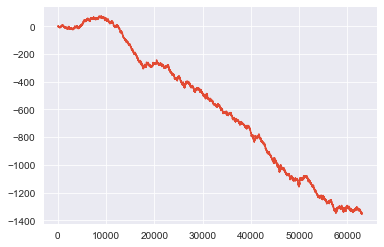

In [57]:
plt.plot(pd.Series(res).cumsum())

In [58]:
#etude de la convergence
#On calcule à chaque étape la valeur moyenne du gain cumulé au dernier jour

conv = [pd.Series(L[0]).cumsum()[len(L[0]) - 1]]
for i in range(1, len(L)):
    moy = ((conv[i-1] * i) + pd.Series(L[i]).cumsum()[len(L[i]) - 1]) / (i + 1)
    conv.append(moy)

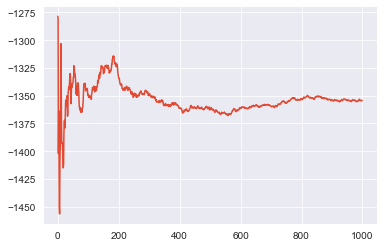

In [59]:
plt.plot(conv)

In [60]:
#Memes opérations que précédemment pour B365
p1_B365 = list(df.p1_B365)
p2_B365 = list(df.p2_B365)

L_B365 = []
import random

for i in range(1000):
    l = []
    for j in range(len(p1_B365)):
        if random.randint(0,1) > 0.5:
            if p1_win[j] == True:
                l.append(p1_B365[j] - 1)
            else:
                l.append(- 1)
        else:
            if p1_win[j] == False:
                l.append(p2_B365[j] - 1)
            else:
                l.append(- 1)
    L_B365.append(l)

In [61]:
res_B365 = []
for i in range(len(L_B365[0])):
    x = 0
    for j in range(len(L_B365)):
        x = x + L_B365[j][i]
    res_B365.append(x / len(L_B365))

In [62]:
conv_B365 = [pd.Series(L_B365[0]).cumsum()[len(L_B365[0]) - 1]]
for i in range(1, len(L_B365)):
    moy = ((conv_B365[i-1] * i) + pd.Series(L_B365[i]).cumsum()[len(L_B365[i]) - 1]) / (i + 1)
    conv_B365.append(moy)

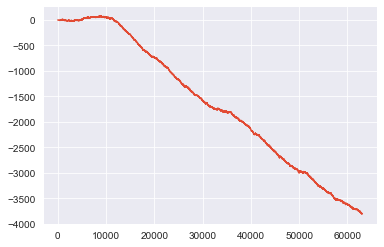

In [63]:

plt.plot(pd.Series(res_B365).cumsum());

In [64]:
#jouer plus faible cote Pinnacle
cpt = 0
l = []

#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):     
    if df["p1_PS"].iloc[i] < df["p2_PS"].iloc[i]:
        cpt = cpt + 1
        if df["p1_win"].iloc[i] == True:
            l.append(df["p1_PS"].iloc[i] - 1)
        else:
            l.append(-1)
    else:
        l.append(0)
        
smallP = pd.Series(l)

print(cpt)

30949


In [65]:
#jouer plus forte cote Pinnacle
cpt = 0
l = []

#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):     
    if df["p1_PS"].iloc[i] > df["p2_PS"].iloc[i]:
        cpt = cpt + 1
        if df["p1_win"].iloc[i] == True:
            l.append(df["p1_PS"].iloc[i] - 1)
        else:
            l.append(-1)
    else:
        l.append(0)
        
bigP = pd.Series(l)

print(cpt)

31913


In [66]:
#jouer plus faible cote B365
cpt = 0
l = []

#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):     
    if df["p1_B365"].iloc[i] < df["p2_B365"].iloc[i]:
        cpt = cpt + 1
        if df["p1_win"].iloc[i] == True:
            l.append(df["p1_B365"].iloc[i] - 1)
        else:
            l.append(-1)
    else:
        l.append(0)
        
smallB365 = pd.Series(l)

print(cpt)

30504


In [67]:
#jouer plus forte cote B365
cpt = 0
l = []

#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):     
    if df["p1_B365"].iloc[i] > df["p2_B365"].iloc[i]:
        cpt = cpt + 1
        if df["p1_win"].iloc[i] == True:
            l.append(df["p1_B365"].iloc[i] - 1)
        else:
            l.append(-1)
    else:
        l.append(0)
        
bigB365 = pd.Series(l)

print(cpt)

31497


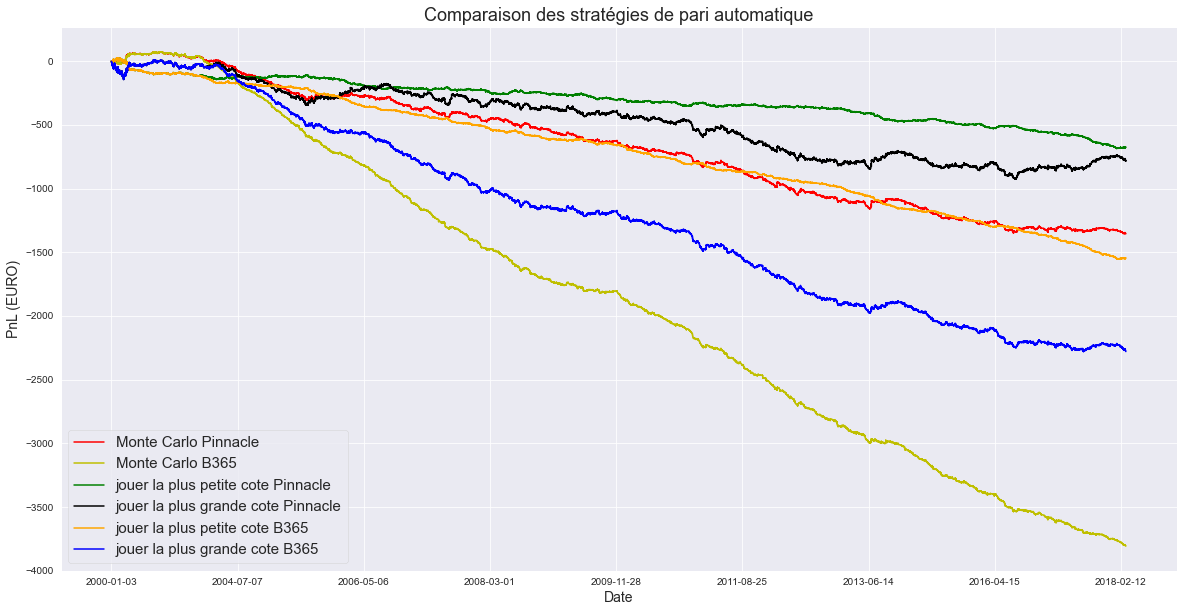

In [68]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(111)

t = ax1.set_title("Comparaison des stratégies de pari automatique", fontsize = 18)

#ax1.plot(df.Date, df.PnLP_small / 2,"c", label = "P&L small")
ax1.plot(df.Date, pd.Series(res).cumsum(),"r", label = "Monte Carlo Pinnacle")
ax1.plot(df.Date, pd.Series(res_B365).cumsum(),"y", label = "Monte Carlo B365")
ax1.plot(df.Date, smallP.cumsum(),"g", label = "jouer la plus petite cote Pinnacle")
ax1.plot(df.Date, bigP.cumsum(),"k", label = "jouer la plus grande cote Pinnacle")
ax1.plot(df.Date, smallB365.cumsum(),"orange", label = "jouer la plus petite cote B365")
ax1.plot(df.Date, bigB365.cumsum(),"blue", label = "jouer la plus grande cote B365")

locs_x, labels_x = plt.xticks()
locs_y, labels_y = plt.yticks()
loc_x_new = np.arange(locs_x[0], locs_x[-1], step = 500)
plt.xticks(loc_x_new)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.xlabel("Date", fontsize = 14)
plt.ylabel("PnL (EURO)", fontsize = 14)

ax1.legend(loc = "lower left",  fontsize = 15);

In [69]:
#Nous tracons une heatmap de la correlation des cotes et de la cote elo
odds = df[["p1_PS", "p2_PS", "p1_B365", "p2_B365"]]

In [70]:
odds["cote_elo"] = 1 / df["proba_elo"]

C:\Users\Olia\AppData\Local\Temp/ipykernel_3272/1392484851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds["cote_elo"] = 1 / df["proba_elo"]


<AxesSubplot:>

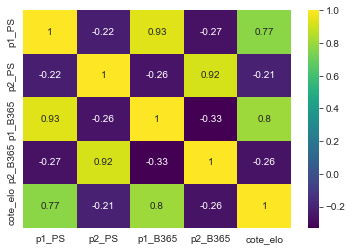

In [71]:
sns.heatmap(odds.corr(), annot = True, cmap = "viridis")

In [72]:
Delta = df["p1_PS"] - df["p1_B365"]

In [73]:
#important pour l'estimation de la différence de gain Mediane de la diff ==>0.04 cf.rapport
Delta.describe()

count    63044.000000
mean         0.196650
std          1.192305
min         -9.950000
25%          0.000000
50%          0.040000
75%          0.132000
max         80.000000
dtype: float64

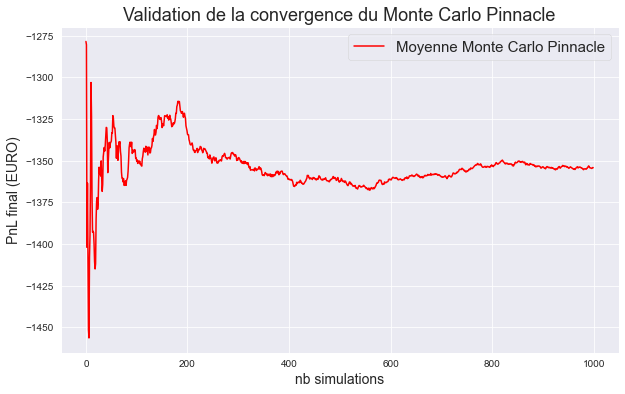

In [74]:
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(111)

t = ax1.set_title("Validation de la convergence du Monte Carlo Pinnacle", fontsize = 18)

#ax1.plot(df.Date, df.PnLP_small / 2,"c", label = "P&L small")
ax1.plot([i for i in range(1000)], conv,"r", label = "Moyenne Monte Carlo Pinnacle")



plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.xlabel("nb simulations", fontsize = 14)
plt.ylabel("PnL final (EURO)", fontsize = 14)

ax1.legend(loc = "upper right",  fontsize = 15);

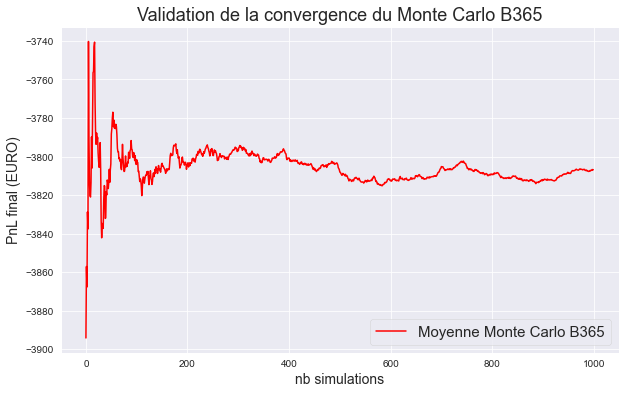

In [75]:
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(111)

t = ax1.set_title("Validation de la convergence du Monte Carlo B365", fontsize = 18)

#ax1.plot(df.Date, df.PnLP_small / 2,"c", label = "P&L small")
ax1.plot([i for i in range(1000)], conv_B365,"r", label = "Moyenne Monte Carlo B365")


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.xlabel("nb simulations", fontsize = 14)
plt.ylabel("PnL final (EURO)", fontsize = 14)

ax1.legend(loc = "lower right",  fontsize = 15);

In [76]:
#Etude de l'accuracy en fonction d'un seuil de cote
path = "..//Data//atp_data_clean.csv"
df = pd.read_csv(path)
df.columns

Index(['Unnamed: 0', 'ATP', 'Location', 'Tournament', 'Date', 'Series',
       'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank',
       'LRank', 'Wsets', 'Lsets', 'Comment', 'PSW', 'PSL', 'B365W', 'B365L',
       'elo_winner', 'elo_loser', 'proba_elo', 'DeltaW', 'DeltaL',
       'gainP_small', 'gainB_small', 'PnLP_small', 'PnLB_small', 'gainP_big',
       'gainB_big', 'PnLP_big', 'PnLB_big'],
      dtype='object')

In [77]:
df["Winner_qcut"] = pd.qcut(df["PSW"], 5, labels=[1,2,3,4,5])

In [78]:
#Calcul de l'accuracy
#selection d'un sous ensemble de match où au moins une des cotes est inférieur à x et comptage de son cardinal :
#total = df.loc[(df["PSW"] < x) | (df["PSL"] < x)]["PSW"].count()
#sur ce sous ensemble on calcule le cardinal de l'ensemble où le favori perd
#On calcule l'accuracy de la manière suivante : accuracy = (total - nbloose) / total
#On calcule de meme la representativité des sous ensembles : Card(sous ensemble) : Card(ensemble total)
#pour savoir sur quel pourcentage des datas on a tel ou tel accuracy
#On calcule de meme la cote limite moyenne (cf. rapport)

acc = []
tot = []
tot_mean_odd = []
tot_mean_oddB365 = []
limitwin = []

for x in np.linspace(1.01, 2.5, 200):
    total = df.loc[(df["PSW"] < x) | (df["PSL"] < x)]["PSW"].count()
    nbloose =  df.loc[(df["PSL"] < x) & (df["PSL"] < df["PSW"])]["PSW"].count()
    
    accuracy = (total - nbloose) / total
    limitwin.append(1 + ((1 - accuracy)/ accuracy))
    tot_mean_odd.append(df.loc[((df["PSW"] < x) | (df["PSL"] < x)) & (df["PSW"] < df["PSL"])]["PSW"].mean())
    tot_mean_oddB365.append(df.loc[((df["B365W"] < x) | (df["B365L"] < x)) & (df["B365W"] < df["B365L"])]["B365W"].mean())
    acc.append(accuracy)
    tot.append(total / df.shape[0])

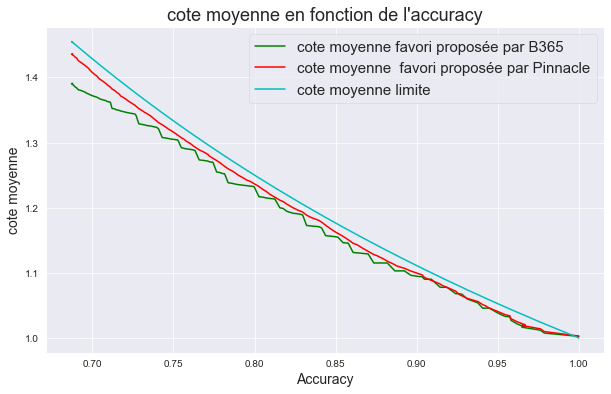

In [79]:
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(111)

t = ax1.set_title("cote moyenne en fonction de l'accuracy", fontsize = 18)

#ax1.plot(df.Date, df.PnLP_small / 2,"c", label = "P&L small")

ax1.plot(acc, tot_mean_oddB365,"g", label = "cote moyenne favori proposée par B365")
ax1.plot(acc, tot_mean_odd,"r", label = "cote moyenne  favori proposée par Pinnacle")
ax1.plot(acc, limitwin,"c", label = "cote moyenne limite")

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.xlabel("Accuracy", fontsize = 14)

ax1.set_ylabel("cote moyenne", fontsize = 14)

ax1.legend(loc = "best",  fontsize = 15);

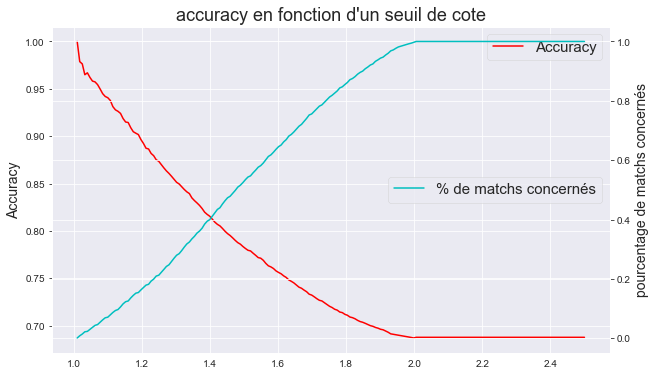

In [80]:
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(111)

t = ax1.set_title("accuracy en fonction d'un seuil de cote", fontsize = 18)

#ax1.plot(df.Date, df.PnLP_small / 2,"c", label = "P&L small")
ax2 = ax1.twinx()

ax1.plot(np.linspace(1.01, 2.5, 200), acc,"r", label = "Accuracy")
ax2.plot(np.linspace(1.01, 2.5, 200), tot,"c", label = "% de matchs concernés")

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.xlabel("seuil de cote", fontsize = 14)

ax1.set_ylabel("Accuracy", fontsize = 14)
ax2.set_ylabel("pourcentage de matchs concernés", fontsize = 14)

ax1.legend(loc = "best",  fontsize = 15);
ax2.legend(loc = "center right",  fontsize = 15);